# What temperature are the spots of TRAPPIST-1?

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import emcee
import os
from scipy.optimize import fmin_powell

import sys
sys.path.insert(0, '../')

In [41]:
from astropy.io import ascii, fits
from astropy.modeling.blackbody import blackbody_lambda
phoenix = fits.getdata('../libra/data/phoenix/lte026.0-4.5-0.0a+0.0.BT-Settl.spec.fits')

kplr = ascii.read('../libra/data/filters/kepler_response_hires1.txt')
kplr_wavelength, kplr_trans = kplr['col1'], kplr['col2']
phoenix_wavelength = phoenix['Wavelength']*1000 * u.nm
phoenix_flux = phoenix['Flux'] / phoenix['Flux'].max()

kplr = ascii.read('../libra/data/filters/kepler_response_hires1.txt')


bb_2559 = blackbody_lambda(phoenix_wavelength, 2559)
bb_2600 = blackbody_lambda(phoenix_wavelength, 2600)

# plt.plot(kplr_wavelength, kplr_trans)
# plt.plot(phoenix_wavelength, phoenix_flux)
# trappist_flux = phoenix_flux * bb_2559.value/bb_2600.value
# plt.plot(phoenix_wavelength, trappist_flux)
# plt.xlim([200, 1000])

([], <a list of 0 Text yticklabel objects>)

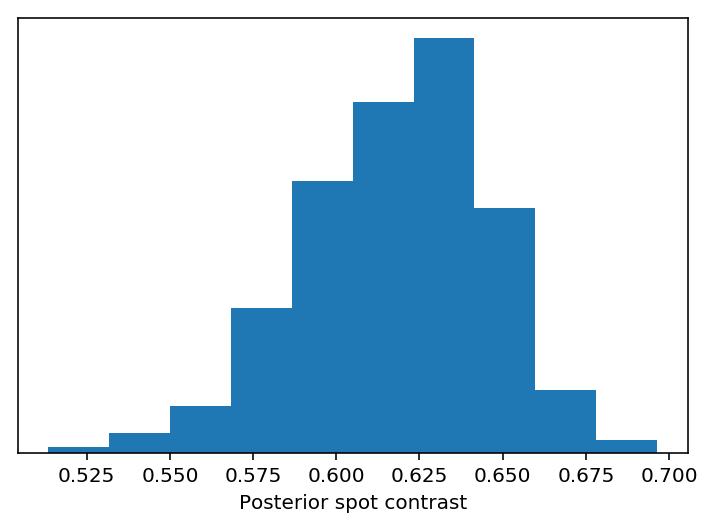

In [43]:
posterior_samples = np.loadtxt('trappist1_spotmodel_posteriors.txt')
median_contrast = np.median(posterior_samples[:, -1])
plt.hist(posterior_samples[:, -1])
plt.xlabel('Posterior spot contrast')
plt.yticks([])

In [8]:
median_contrast = 0.62

def minimize(p):
    bb_trial = blackbody_lambda(phoenix_wavelength, p[0]*u.K).value
    bb_2559 = blackbody_lambda(phoenix_wavelength, 2559*u.K).value

    trans_interp = np.interp(phoenix_wavelength, kplr_wavelength, kplr_trans, left=0, right=0)
    
    spot_spectrum = phoenix_flux * bb_trial / bb_2559
    
    contrast = (1 - np.trapz(spot_spectrum * trans_interp * phoenix_wavelength, x=phoenix_wavelength) / 
                np.trapz(phoenix_flux * trans_interp * phoenix_wavelength, x=phoenix_wavelength))
    return np.abs(contrast - median_contrast)
    

spot_temperature = fmin_powell(minimize, [2500])
spot_temperature

/Users/bmmorris/anaconda/lib/python3.5/site-packages/astropy-3.0.dev19880-py3.5-macosx-10.6-x86_64.egg/astropy/units/quantity.py:641: RuntimeWarning: overflow encountered in expm1
  *arrays, **kwargs)
/Users/bmmorris/anaconda/lib/python3.5/site-packages/astropy-3.0.dev19880-py3.5-macosx-10.6-x86_64.egg/astropy/units/quantity.py:641: RuntimeWarning: overflow encountered in multiply
  *arrays, **kwargs)


Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 6
         Function evaluations: 214


<Quantity 2253.0375682680306>

In [9]:
2559 - spot_temperature

<Quantity 305.96243173196945>

In [31]:
spitz_1 = ascii.read('../libra/data/filters/Spitzer_IRAC.I1.txt')
spitz1_wave = (spitz_1['col1'] * u.Angstrom).to(u.nm)
spitz1_trans = spitz_1['col2']

spitz_2 = ascii.read('../libra/data/filters/Spitzer_IRAC.I2.txt')
spitz2_wave = (spitz_2['col1'] * u.Angstrom).to(u.nm)
spitz2_trans = spitz_2['col2']

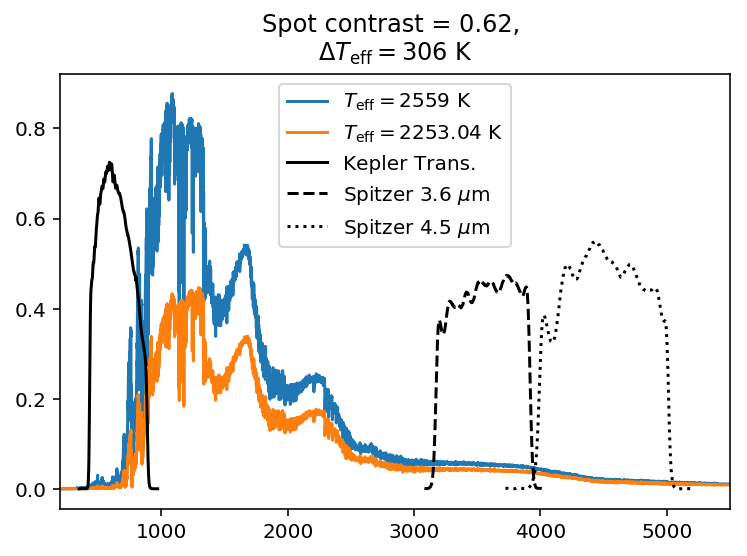

In [34]:
from scipy.ndimage import gaussian_filter1d

#plt.plot(phoenix_wavelength, phoenix_flux)

bb_2559 = blackbody_lambda(phoenix_wavelength, 2559)
bb_2600 = blackbody_lambda(phoenix_wavelength, 2600)
bb_spot = blackbody_lambda(phoenix_wavelength, spot_temperature.value)

trappist_flux = phoenix_flux * bb_2559.value/bb_2600.value
plt.plot(phoenix_wavelength, gaussian_filter1d(trappist_flux, 100), 
         label='$T_\mathrm{eff} = 2559$ K')

trappist_spot = trappist_flux * bb_spot/bb_2559

plt.plot(phoenix_wavelength, gaussian_filter1d(trappist_spot, 100), 
         label='$T_\mathrm{{eff}} = {0:.2f}$ K'.format(spot_temperature.value))

plt.plot(kplr_wavelength, kplr_trans, color='k', label='Kepler Trans.')
plt.plot(spitz1_wave, spitz1_trans, color='k', ls='--', label='Spitzer 3.6 $\mu$m')
plt.plot(spitz2_wave, spitz2_trans, color='k', ls=':', label='Spitzer 4.5 $\mu$m')

plt.title('Spot contrast = {0}, \n$\Delta T_\mathrm{{eff}} = {1:.0f}$ K'
          .format(median_contrast, 2559 - spot_temperature.value))
plt.xlim([200, 5500])
plt.legend()
plt.show()

In [39]:
for spitz, channel in zip([[spitz1_wave, spitz1_trans], [spitz2_wave, spitz2_trans]], 
                          ['3.6 um', '4.5 um']):
    spitz_wave, spitz_trans = spitz
    trans_interp = np.interp(phoenix_wavelength, spitz_wave, spitz_trans, left=0, right=0)

    contrast = (1 - np.trapz(trappist_spot * trans_interp * phoenix_wavelength, x=phoenix_wavelength) / 
                np.trapz(phoenix_flux * trans_interp * phoenix_wavelength, x=phoenix_wavelength))
    
    print("{0}: c={1}".format(channel, contrast))

3.6 um: c=0.2559045743914061
4.5 um: c=0.22968164280342562
